In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
from imutils.video import FPS
import numpy as np

In [14]:
with open(r"C:\Users\Hard Parikh\Desktop\YOLO_OPENCV\model_data\coco.names.txt",'r',encoding='utf-8') as f:
    labels=f.read().strip().split('\n')

In [15]:
yolo_config_path=r"C:\Users\Hard Parikh\Desktop\YOLO_OPENCV\model_data\yolov4.cfg.txt"
yolo_weights=r"C:\Users\Hard Parikh\Desktop\YOLO_OPENCV\model_data\yolov4.weights"
input_image=r"C:\Users\Hard Parikh\Desktop\YOLO_OPENCV\input_image\1_EYFejGUjvjPcc4PZTwoufw.jpeg"
cuda=True
show_display=True
write_output=True
output_image_path=r"C:\Users\Hard Parikh\Desktop\YOLO_OPENCV\output_image\output_image_.jpg"
confidence_threshold=0.9
overlapping_threshold=0.3

In [16]:
# cpu 
net=cv2.dnn.readNetFromDarknet(yolo_config_path,yolo_weights)

In [17]:
# gpu
if(cuda==True):
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [18]:
def get_yolo_preds(net, input_img_path=input_image, output_img_path=output_image_path, confidence_threshold=confidence_threshold, overlapping_threshold=overlapping_threshold, write_output=write_output, show_display=show_display, labels =labels):
    np.random.seed(123)
    colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    W = None
    H = None
    image=cv2.imread(input_img_path)
    success=True
    while success:
        # frame = imutils.resize(frame, width=640)
        if W is None or H is None:
            (H, W) =image.shape[:2]

        # Construct blob of frames by standardization, resizing, and swapping Red and Blue channels (RBG to RGB)
        blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        layerOutputs = net.forward(ln)
        boxes = []
        confidences = []
        classIDs = []
        for output in layerOutputs:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]
                if confidence > confidence_threshold:
                    # Scale the bboxes back to the original image size
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        bboxes = cv2.dnn.NMSBoxes(
            boxes, confidences, confidence_threshold, overlapping_threshold)
        if len(bboxes) > 0:
            for i in bboxes.flatten():
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])
                color = [int(c) for c in colors[classIDs[i]]]
                cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)
                text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
                cv2.putText(image, text, (x, y - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        if show_display:
            plt.imshow(image)
            plt.show()

        if write_output:
            cv2.imwrite(output_img_path,image)
        break

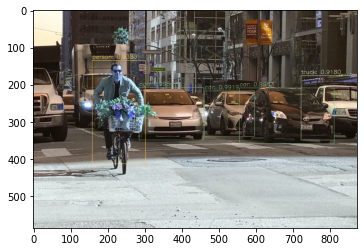

In [19]:
get_yolo_preds(net)